# 데이터 결측치 처리

앞서 간단한 결측치 처리를 진행했지만, EDA를 통해서 추가적인 결측치 처리의 필요성을 알게되었습니다.  
결측치 처리는 다음과 같은 순서로 진행됩니다. 
1. action_type: `온라인 행동 유형` 처리
2. biz_unit: `weekday`, `holiday`
3. 변수 생성: `hour`
4. 변수 생성: `latest`
5. 변수 생성: `prefer_dvc`
6. 변수 생성: `trfc_dvc`
7. 외부데이터: `온도`, `습도`, `강수량`, `강수형태`
<br><br>

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.font_manager as fm
path = 'data/font/NanumGothic-ExtraBold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

## load data

In [8]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}

online = pd.read_csv('./data/online_01.csv', dtype=cks_dtype)
trade = pd.read_csv('./data/trade_01.csv', dtype=cks_dtype)
customer = pd.read_csv('./data/customer_01.csv', dtype=cks_dtype)
item = pd.read_csv('./data/item_01.csv', dtype=cks_dtype)

### 1-4. action_type : 온라인 행동 유형
 *  0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 
 * 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션

 * 온라인 행동 유형는 몇 개나 있는가?? => 8개
 
     * class 갯수는 9개이므로 존재하지 않는 행동 하나 있음
         * '8. 결재 옵션'은 데이터 존재하지 않음(하단 확인)

In [11]:
online['action_type'].value_counts()

5    750530
2    655266
0    651638
3    596765
1    307998
4    172240
6     56249
7      5676
Name: action_type, dtype: int64

 * 온라인 행동 유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 75만 건 , 최소 5600건
     * 제일 많은 행동은 약 75만 건의 '5. 결제 시도' 이며
     * 제일 적은 행동은 약 5600건의 '7. 구매 환불' 임
     * '8. 결재 옵션'은 데이터 존제하지 않음이 확인됨

In [12]:
online['action_type'].isna().sum()

0

 * 결측치 갯수 확인 => 없음

#### 온라인 행동 유형 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

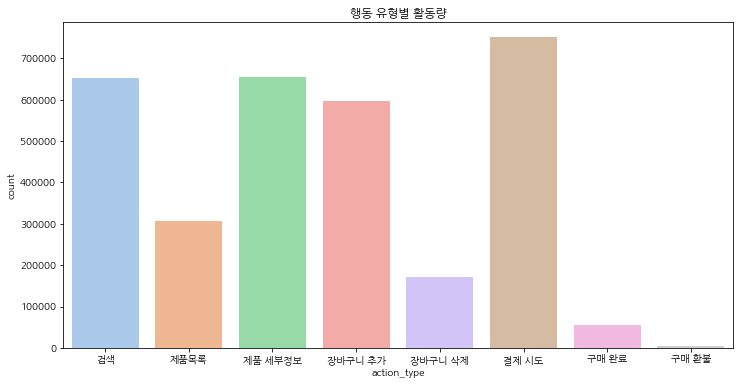

In [13]:
title = '행동 유형별 활동량'
plt.figure(figsize=(12,6))
sns.countplot(x= 'action_type', data=online, palette="pastel")
action_labels = ['검색','제품목록','제품 세부정보','장바구니 추가','장바구니 삭제','결제 시도','구매 완료','구매 환불']
plt.xticks(ticks=np.arange(8), labels = action_labels)
plt.title(title)
plt.savefig(f'../image/2.1.{title}.png', dpi=300)
plt.show

결제 시도에서 구매 완료까지 가는 인원이 현저히 줄어듬을 확인 할 수 있음.  
몇가지 추가 분석이 필요함.  
1. 결제 중복 시도가 3회 이상인 고객의 비율
2. 결제 시도를 했으나 구매 완료까지 가지 않은 고객의 비율

#### 1-4-1. 결제 중복 시도 확인


In [14]:
from tqdm import tqdm

다른 ID인지, 다른 날짜 인지 고려할 필요하다. 

In [15]:
def OverlabAct(data, k):
    temp = 0
    overlab = []
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        # act가 k 이면, +1한다. 
        if row['action_type'] == 5:
            temp = temp +1
        # act가 달라지면 중복 횟수만큼 저장하게된다. 
        else:
            overlab.append(temp)
            temp = 0
    return np.array(overlab)

In [17]:
np_over = OverlabAct(online, 5)

print('3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over[np_over>=3].sum()/np_over.sum(),3)*100, '%')
print('5번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over[np_over>=5].sum()/np_over.sum(),2)*100, '%')

100%|██████████| 3196362/3196362 [02:38<00:00, 20174.92it/s]


3번 이상 연속으로 결제 시도가 중복된 비율: 49.9 %
5번 이상 연속으로 결제 시도가 중복된 비율: 24.0 %


In [19]:
np_over

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
test = (np_over>=1).astype(np.int8)

6 0 0 0 1 0 0 1 3 0 0 = 11

1 0 0 0 1 0 0 1 1 0 0 = 4

4 / 11 = 

In [416]:
test.sum() / np_over.sum() 

0.5222762581109349

#### 1-4-2. 결제 시도 후 구매 완료를 안한 비율

이번에는 결제 시도를 했지만 구매 완료까지 도달하지 않은 비율을 확인해보겠습니다.  
이를 위해 여러번 중복 시도해도 한번 결제 시도를 한 걸로 보겠습니다.  

In [419]:
print('결제 시도 횟수:', np_over[np_over != 0].shape[0])
print('결제 완료 횟수:', (online['action_type'] == 6).sum())
print('결제 시도를 하고 구매를 한 비율:', round((online['action_type'] == 6).sum()/np_over[np_over != 0].shape[0], 4)*100, '%')

결제 시도 횟수: 391984
결제 완료 횟수: 56249
결제 시도를 하고 구매를 한 비율: 14.35 %


In [422]:
(online['action_type'] == 6).sum() / np_over.sum() *100

7.494570503510853

In [417]:
online[online['action_type'] == 6]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,grade
46,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,61.0,911.0,DIRECT,unknown,5.0
145,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,5.0
167,2,10,16,6,A03,20190801,22:00,306944,65505.0,NaN,23.0,353.0,DIRECT,unknown,5.0
247,2,19,17,6,A03,20190830,22:00,2227390,88495.0,NaN,29.0,2253.0,DIRECT,unknown,5.0
270,4,1,2,6,A01,20190826,10:38,402600,85046.0,NaN,115.0,950.0,unknown,mobile_app,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196182,72418,3,12,6,A02,20190919,12:52,2359650,104648.0,NaN,22.0,2360.0,unknown,PC,6.0
3196189,72419,1,5,6,A02,20190902,21:19,743203,90888.0,NaN,39.0,743.0,unknown,mobile_web,6.0
3196201,72423,1,1,6,A01,20190917,11:48,116283,102596.0,NaN,24.0,114.0,unknown,mobile_app,6.0
3196293,72424,2,52,6,A03,20190924,17:12,2410463,108506.0,NaN,82.0,2445.0,PORTAL_1,PC,5.0


<br>
결제 시도 후에 결제 완료까지 이어지는 비율이 현저히 낮습니다. 

### 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 업종단위는 몇 개나 있는가?? => 3개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

 * 업종단위 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 23만 건 , 최소 19만건

<AxesSubplot:xlabel='biz_unit', ylabel='count'>

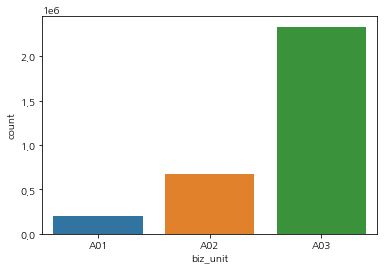

In [154]:
sns.countplot(online['biz_unit'])

온라인 업종 별로 인원수 차이가 큽니다.  
왜 이렇게 업종별로 데이터 차이가 큰 것인지 궁금합니다.  
중복 수가 많다는 가정을 하고, 유니크한 매장별 고객수를 뽑아보겠습니다. 

In [425]:
test = pd.DataFrame(raw_data2_Trade_Inform.groupby('clnt_id')['biz_unit'].apply(lambda x: ','.join(set(x))))

<AxesSubplot:xlabel='biz_unit', ylabel='count'>

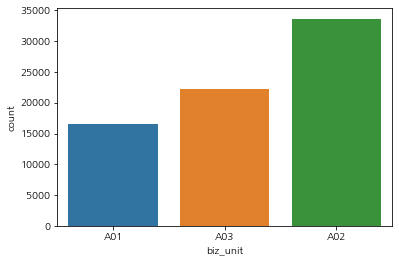

In [189]:
uniq_clnt = pd.DataFrame(online.groupby('clnt_id')['biz_unit'].apply(lambda x: ','.join(set(x))))
sns.countplot(uniq_clnt['biz_unit'])

그런데 고객과 매장을 그룹으로 묶어서 중복을 제거해보니,  
실질적인 고객 수는 A03이 더 많은 모습을 볼 수 있었습니다.

**의견** A03 매장에서는 한 고객이 많이 구매했을 수도 있다.  
매장 별로 경향성이 있는 지 파악을 해보는 게 중요할 것 같다.  
이거 자체가 영향을 끼치는 지 명확하지 않다.  
유의미 하지 않으면 밸런싱 할 필요가 없어보인다. 

그래서 이 부분에 대해서 두가지 더 살펴보았습니다. 
1. 각 매장별로 행동 유형에 대한 중복 확인.
2. 각 매장별 행동 그래프

#### 1-5-1. 각 매장별 행동 유형에 대한 중복 확인

In [5]:
online_A03 = online[online['biz_unit']=='A03']
online_A02 = online[online['biz_unit']=='A02']
online_A01 = online[online['biz_unit']=='A01']

In [4]:
np_over_A03 = OverlabAct(online_A03, 5)
np_over_A02 = OverlabAct(online_A02, 5)
np_over_A01 = OverlabAct(online_A01, 5)

NameError: name 'OverlabAct' is not defined

In [267]:
print('A03에서 3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A03[np_over_A03>=3].sum()/np_over_A03.sum(),3)*100, '%')
print('A02에서 3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A02[np_over_A02>=3].sum()/np_over_A02.sum(),3)*100, '%')
print('A01에서 3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A01[np_over_A01>=3].sum()/np_over_A01.sum(),3)*100, '%')

A03에서 3번 이상 연속으로 결제 시도가 중복된 비율: 52.6 %
A02에서 3번 이상 연속으로 결제 시도가 중복된 비율: 33.1 %
A01에서 3번 이상 연속으로 결제 시도가 중복된 비율: nan %


In [270]:
print('A03에서 2번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A03[np_over_A03>=2].sum()/np_over_A03.sum(),4)*100, '%')
print('A02에서 2번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A02[np_over_A02>=2].sum()/np_over_A02.sum(),4)*100, '%')
print('A01에서 2번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A01[np_over_A01>=2].sum()/np_over_A01.sum(),4)*100, '%')

A03에서 2번 이상 연속으로 결제 시도가 중복된 비율: 67.81 %
A02에서 2번 이상 연속으로 결제 시도가 중복된 비율: 72.5 %
A01에서 2번 이상 연속으로 결제 시도가 중복된 비율: nan %


<br><br>

2번 이상 연속과 3번 이상 연속인 경우 달라지는 모습을 확인 할 수 있습니다.   
중복을 결정하는 숫자도 중요할 것 같습니다. 

#### 1-5-2. 각 매장별 행동 그래프

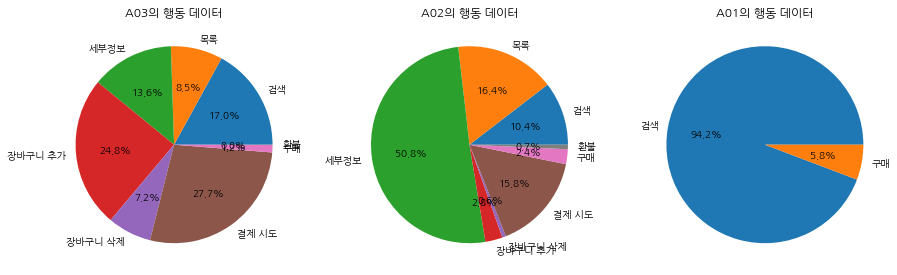

In [262]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
label_3 = ['검색', '목록', '세부정보', '장바구니 추가', '장바구니 삭제', '결제 시도', '구매', '환불']
label_2 = ['검색', '목록', '세부정보', '장바구니 추가', '장바구니 삭제', '결제 시도', '구매', '환불']
label_1 = ['검색', '구매']

axs[0].pie(online_A03['action_type'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_3)
axs[0].set_title('A03의 행동 데이터')

axs[1].pie(online_A02['action_type'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_2)
axs[1].set_title('A02의 행동 데이터')

axs[2].pie(online_A01['action_type'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_1)
axs[2].set_title('A01의 행동 데이터')

plt.show()

각 매장별 행동 데이터에 대한 분포도 다릅니다.  
A03의 경우 결제 시도가 가장 많긴 하지만 대체로 골고루 분포가 되어 있습니다.  
A02의 경우 세부정보가 과반수 넘게 분포되어 있습니다.  
A01의 경우 검색과 구매 데이터만 있습니다. 

### 1-13. dvc_ctg_nm : 기기 유형 

 * mobile_web / mobile_app / PC

 * 기기유형의 종류는 몇 개나 있는가?? => 3개

In [20]:
online_A03 = online[online['biz_unit']=='A03']
online_A02 = online[online['biz_unit']=='A02']
online_A01 = online[online['biz_unit']=='A01']

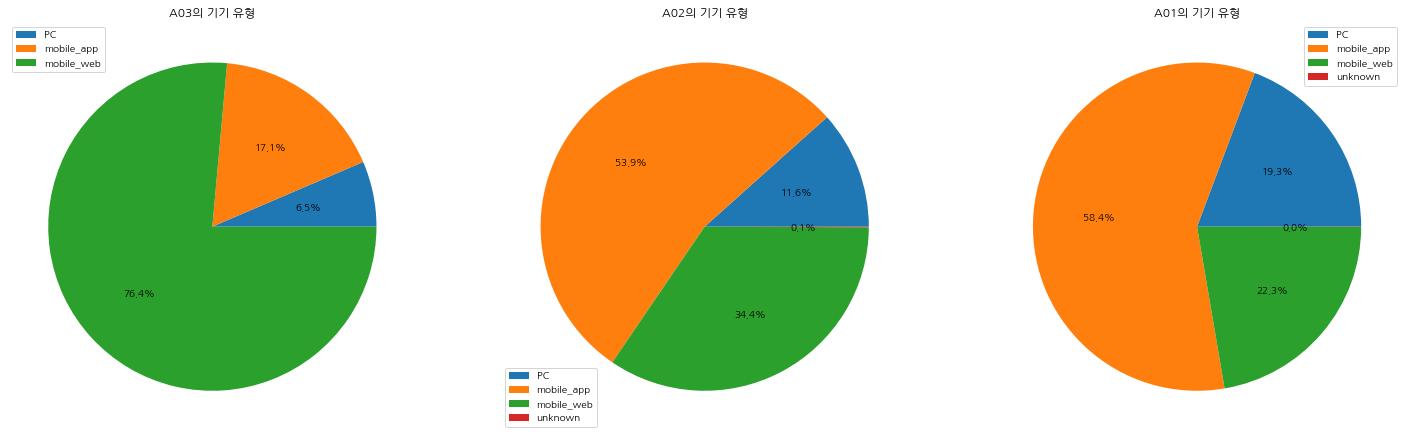

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels = ['PC', 'mobile_app', 'mobile_web', 'unknown']

axs[0].pie(online_A03['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels)
axs[0].set_title('A03의 기기 유형')

axs[1].pie(online_A02['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 기기 유형')

axs[2].pie(online_A01['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 기기 유형')

plt.show()

<br><br>
#### 1-13-1. 결측치 처리
A03의 기기에 유일하게 mobile-app의 정보가 없다.
- A03의 unknown 데이터는 mobile_app으로 변경

In [22]:
online.loc[online['dvc_ctg_nm']=='unknown', 'dvc_ctg_nm'] = 'mobile_app'

In [23]:
online_A03 = online[online['biz_unit']=='A03']
online_A02 = online[online['biz_unit']=='A02']
online_A01 = online[online['biz_unit']=='A01']

In [24]:
online_A03['dvc_ctg_nm'].value_counts().sort_index()

PC             150421
mobile_app    1782081
mobile_web     398935
Name: dvc_ctg_nm, dtype: int64

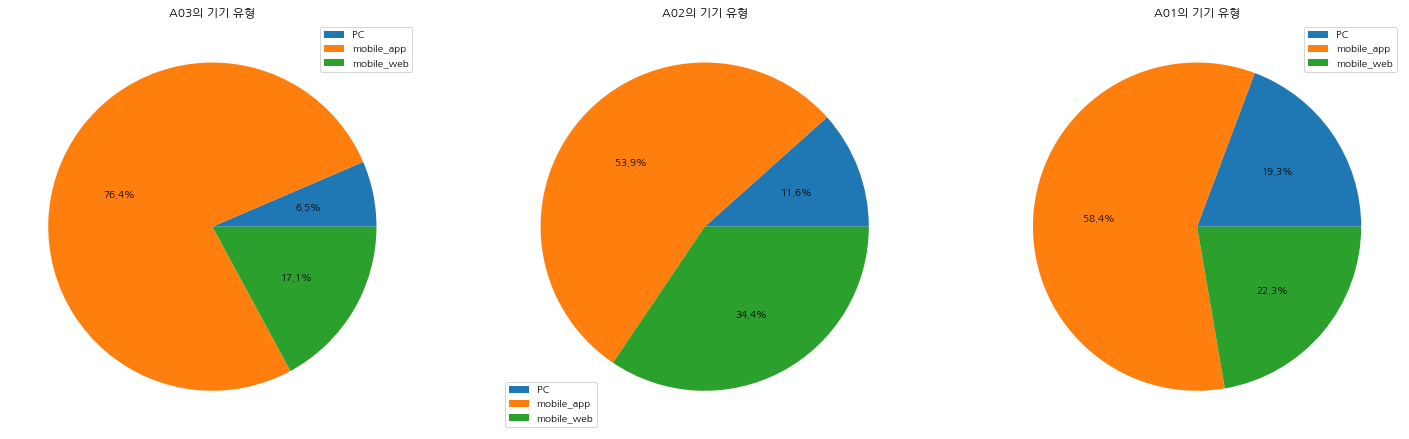

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels1 = ['PC', 'mobile_app',  'mobile_web']
labels2 = ['PC', 'mobile_app', 'mobile_web',  'unknown']

axs[0].pie(online_A03['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels1)
axs[0].set_title('A03의 기기 유형')

axs[1].pie(online_A02['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels2)
axs[1].set_title('A02의 기기 유형')

axs[2].pie(online_A01['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels2)
axs[2].set_title('A01의 기기 유형')

plt.show()

<br><br>
### 1-14. trfc_src : 유입 채널 

 * 종류 : DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown

 * 유입채널의 종류는 몇 개나 있는가?? => 7개

In [26]:
online['trfc_src'].nunique()

7

 * 유입채널 별 온라인 행동데이터는 몇 건이 있는지? => 최대 171만건 , 최소 9792건

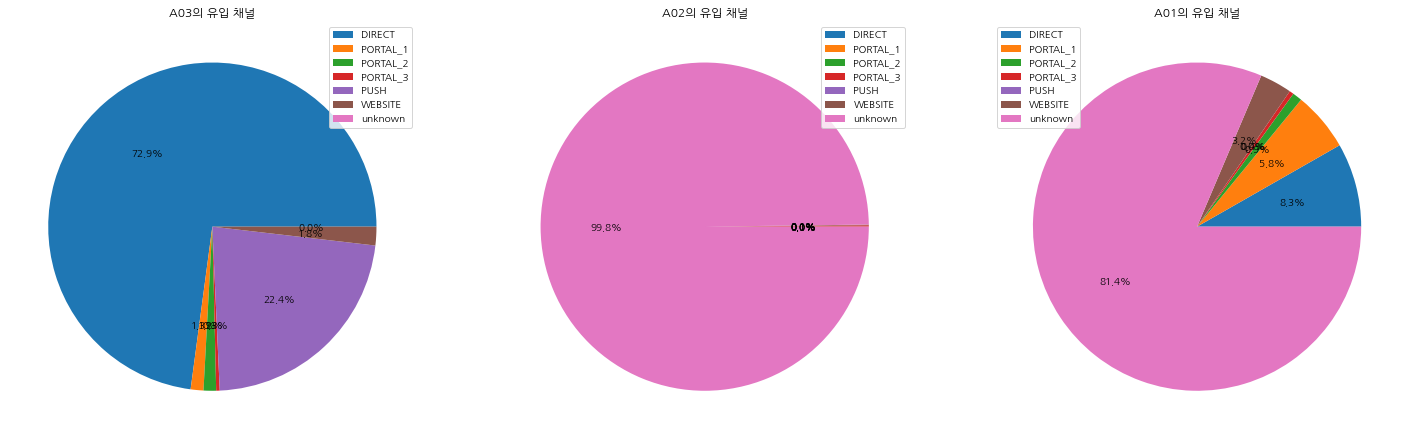

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels = ['DIRECT', 'PORTAL_1', 'PORTAL_2', 'PORTAL_3', 'PUSH', 'WEBSITE', 'unknown']

axs[0].pie(online_A03['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels)
axs[0].set_title('A03의 유입 채널')

axs[1].pie(online_A02['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 유입 채널')

axs[2].pie(online_A01['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 유입 채널')

plt.show()

<br><br>
#### 1-14-1. 결측치 처리
기기 유형으로 유입채널의 unknown 데이터를 임의로 채울 수 있을 것 같습니다.  
다음과 같은 순서로 진행됩니다.  
- A03를 기반으로 A01의 unknown 데이터 채우기
- 관계를 분석한 기반으로 unknown 데이터 채우기

In [28]:
import random
def random_choise(data, dvc):
    x = data.copy()
    c_nm2_choiced = []
    data_dvc = online_A03[online_A03['dvc_ctg_nm'] == dvc]['trfc_src']
    c_nm2_list = data_dvc.value_counts().index
    probs = list(data_dvc.value_counts() / data_dvc.count())
    for i in x.index:
        if (x.loc[i,['trfc_src']] == 'unknown')['trfc_src']:
            x.loc[i,['trfc_src']] = random.choices(c_nm2_list, weights = probs)[0]
    return x

In [29]:
def change_trfc(dvc):
    online_A02_app = online_A02[online_A02['dvc_ctg_nm'] == dvc]
    online_A01_app = online_A01[online_A01['dvc_ctg_nm'] == dvc]

    online_A02[online_A02['dvc_ctg_nm'] == dvc] = random_choise(online_A02_app, dvc)
    online_A01[online_A01['dvc_ctg_nm'] == dvc] = random_choise(online_A01_app, dvc)

In [30]:
def plot_trfc(dvc):
    fig, axs = plt.subplots(3, 1, figsize=(8,6))
    plt.subplots_adjust(hspace=0.8)
    sns.countplot(online_A03[online_A03['dvc_ctg_nm'] == dvc]['trfc_src'], ax=axs[0]).set_title('A03_'+dvc)
    sns.countplot(online_A02[online_A02['dvc_ctg_nm'] == dvc]['trfc_src'], ax=axs[1]).set_title('A02_'+dvc)
    sns.countplot(online_A01[online_A01['dvc_ctg_nm'] == dvc]['trfc_src'], ax=axs[2]).set_title('A01_'+dvc)

- mobile_app을 기준으로 채우기

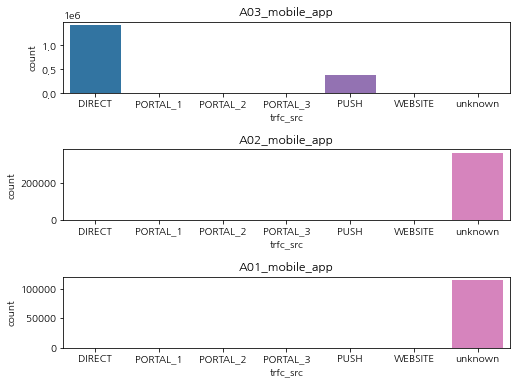

In [31]:
dvc = 'mobile_app'
plot_trfc(dvc)

mobile_app으로 들어올 수 있는 유입 경로는 DIRECT와 PUSH가 있습니다. 

In [32]:
change_trfc(dvc)

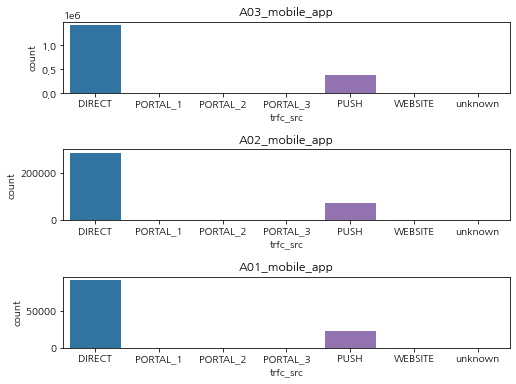

In [33]:
plot_trfc(dvc)

A02와 A01 모두 A03의 그래프와 비슷하게 채워졌습니다. 

- PC를 기준으로 채우기 

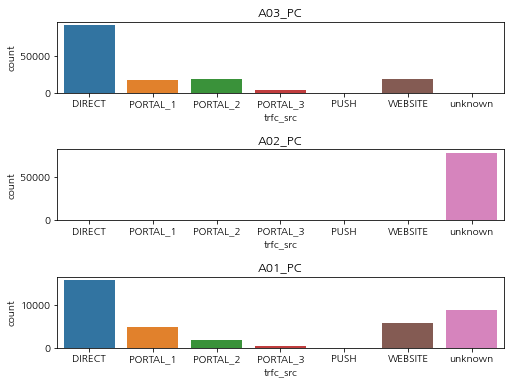

In [34]:
dvc = 'PC'
plot_trfc(dvc)

In [35]:
change_trfc(dvc)

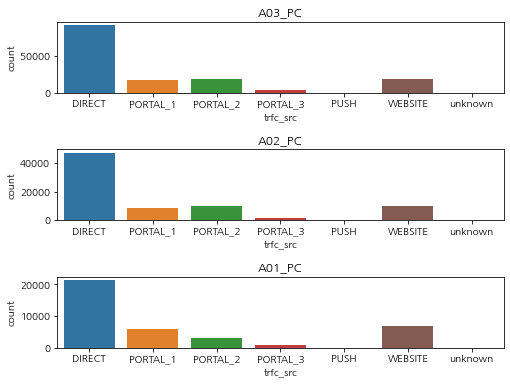

In [36]:
plot_trfc(dvc)

- mobile_web를 기준으로 채우기

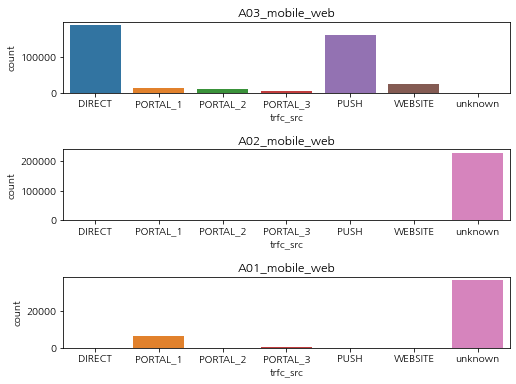

In [37]:
dvc = 'mobile_web'
plot_trfc(dvc)

In [38]:
change_trfc(dvc)

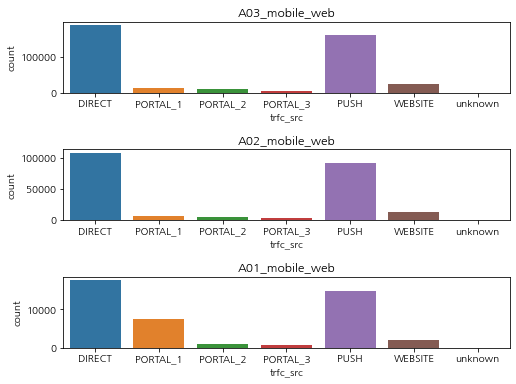

In [39]:
plot_trfc(dvc)

In [40]:
online = pd.concat([online_A01,online_A02,online_A03])

In [42]:
online.to_csv('./data/online_03.csv', index=False)

### 2-9. buy_ct : 구매 수량

 * 구매수량은 몇 종류나 있는가?? => 338개

In [93]:
raw_data2_Trade_Inform['buy_ct'].nunique()

338

 * 구매수량 별 거래정보데이터는 몇 건이 있는지? => 최대 49만건 , 최소 1건

In [94]:
raw_data2_Trade_Inform['buy_ct'].value_counts()

1      497831
2       62837
3       12371
0        6775
4        6377
        ...  
210         1
207         1
717         1
204         1
155         1
Name: buy_ct, Length: 338, dtype: int64

 * NaN 갯수 확인 => 없음
     * 위 최소 수량 0을 결측치로 고려 => 6775개

In [95]:
raw_data2_Trade_Inform['buy_ct'].isna().sum()

0

 * 최대 수량은?? => 3600개

In [96]:
max(raw_data2_Trade_Inform['buy_ct'])

3600

 * 최소 수량은?? => 0
     * 결측치로 고려

In [97]:
min(raw_data2_Trade_Inform['buy_ct'])

0

 ## 3. 사용자 demo 정보(나이, 성별) 확인

In [98]:
raw_data3_Demog.head()

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


 * 3-1(=2-1, 1-1). clnt_id : 고객 고유 식별 ID
 * 3-2. clnt_gender : 고객 성별
 * 3-3. clnt_age : 고객 연령대( 10단위:  10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown)

In [99]:
raw_data3_Demog.shape

(72399, 3)

 * 행 수(데이터 갯수) : 7.2만 개
 * 열 수(데이터 종류) : 3개

In [50]:
raw_data3_Demog['clnt_gender'].value_counts().sort_index()

F    10352
M     1893
Name: clnt_gender, dtype: int64

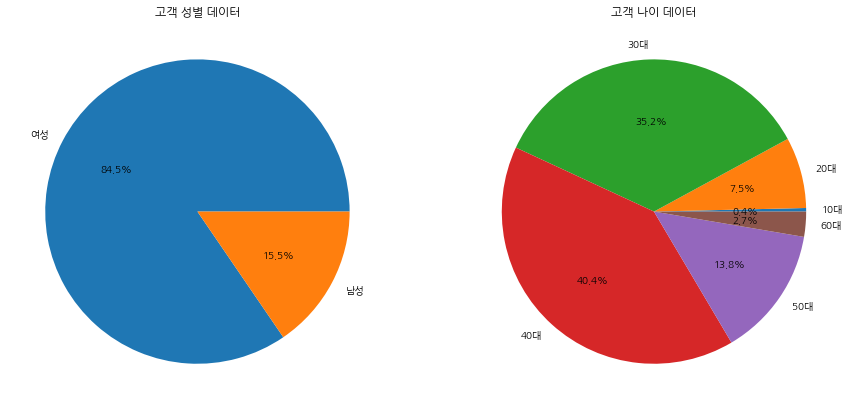

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
label_gender = ['여성', '남성']
label_age = ['10대', '20대', '30대', '40대', '50대', '60대']

axs[0].pie(raw_data3_Demog['clnt_gender'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_gender)
axs[0].set_title('고객 성별 데이터')

axs[1].pie(raw_data3_Demog['clnt_age'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_age)
axs[1].set_title('고객 나이 데이터')

plt.show()

### 3-1. clnt_Id : 고객 고유 식별 ID

 * 1-1, 2-1 clnt_id와 동일 의미

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [100]:
raw_data3_Demog['clnt_id'].nunique()

72399

 * 고객ID 별로 사용자 demog 데이터는 몇 건이 있는지? => 1건
     * 서로 다른 사람이 같은 ID를 공유하는 오류데이터는 없음

In [101]:
raw_data3_Demog['clnt_id'].value_counts()

2047     1
27288    1
14994    1
12947    1
2708     1
        ..
25958    1
32101    1
30052    1
19811    1
2049     1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [102]:
raw_data3_Demog['clnt_id'].isna().sum()

0

### 3-2. clnt_gender : 고객 성별

 * 성별은 몇 개나 있는가?? => 3개 (남, 여, 알수 없음)

In [103]:
raw_data3_Demog['clnt_gender'].nunique()

3

 * 성별 별로 사용자 demog 데이터는 몇 건이 있는지? => 알 수없음 6만, 여성 1만, 남성 1800

In [104]:
raw_data3_Demog['clnt_gender'].value_counts()

unknown    60154
F          10352
M           1893
Name: clnt_gender, dtype: int64

 * 결측치 갯수 확인 => 60154개

### 3-3. clnt_age : 고객 연령대

 * 10단위: 10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown

 * 연령대는 몇 종류나 있는가?? => 7종

In [105]:
raw_data3_Demog['clnt_age'].nunique()

7

 * 연령 별로 사용자 demog 데이터는 몇 건이 있는지?
 
     * 10대 : 46
     * 20대 : 924
     * 30대 : 4307
     * 40대 : 4948
     * 50대 : 1694
     * 60대 : 326
     * 알 수 없음 : 60154

In [106]:
raw_data3_Demog['clnt_age'].value_counts()

unknown    60154
40          4948
30          4307
50          1694
20           924
60           326
10            46
Name: clnt_age, dtype: int64

 * 결측치 갯수 확인 => 60154개

## 4. 상품 대중소 분류 정보

In [107]:
raw_data4_Item_Class.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


* 4-1. pd_c : 상품 소분류 코드
* 4-2. clac_nm1 : 상품 대분류명
* 4-3. clac_nm2 : 상품 중분류명
* 4-4. clac_nm3 : 상품 소분류명

In [108]:
raw_data4_Item_Class.shape

(1667, 4)

 * 행 수(데이터 갯수) : 1667개
 * 열 수(데이터 종류) : 4개

### 4-1. pd_c : 상품의 소분류 코드

 * 2-5. pd_c 데이터와 의미 동일

 * 상품분류데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1667개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [109]:
raw_data4_Item_Class['pd_c'].nunique()

1667

 * 소분류코드 별 상품분류데이터는 몇 건이 있는지? => 각 1건

In [110]:
raw_data4_Item_Class['pd_c'].value_counts()

1667    1
834     1
1098    1
1100    1
1102    1
       ..
563     1
565     1
567     1
569     1
2       1
Name: pd_c, Length: 1667, dtype: int64

 * 결측치 갯수 확인 => 없음

In [111]:
raw_data4_Item_Class['pd_c'].isna().sum()

0

### 4-2. clac_nm1 : 상품 대분류명

 * 상품분류데이터 내 대분류명의 종류는 몇 개나 있는가?? => 60개

In [112]:
raw_data4_Item_Class['clac_nm1'].nunique()

60

 * 대분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 100건, 최소 1건

In [113]:
raw_data4_Item_Class['clac_nm1'].value_counts()

Fashion Accessories                          100
Meats                                         80
Sea Foods                                     76
Vegetables                                    70
Kids' Clothing                                67
Stationary / Office Supplies                  61
Fruits                                        56
Underwear / Socks and Hosiery / Homewear      53
Sport Fashion                                 52
Spices / Seasonings                           49
Cosmetics / Beauty Care                       48
Personal Care                                 38
Snack Foods                                   36
Tableware / Cooking Utensils                  35
Cooked Foods                                  35
Gardening / Pets                              35
Home / Kitchen Appliances                     33
Chilled Foods                                 32
Kitchenware                                   30
Cleaning / Laundry / Bathroom Accessories     30
Bedding / Handicraft

 * 결측치 갯수 확인 => 없음

In [114]:
raw_data4_Item_Class['clac_nm1'].isna().sum()

0

### 4-3. clac_nm2 : 상품 중분류명

 * 상품분류데이터 내 중분류명의 종류는 몇 개나 있는가?? => 332개

In [115]:
raw_data4_Item_Class['clac_nm2'].nunique()

332

 * 중분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 19건, 최소 1건

In [116]:
raw_data4_Item_Class['clac_nm2'].value_counts()

Fish                     19
Kitchen Appliances       17
Imported Fruits          16
Leaf Vegetables          16
Domestic Fruits          16
                         ..
Other Seasonal Sports     1
Ready to Drinks           1
Outdoor Furniture         1
Coffee Drinks             1
Boys' Clothing Sets       1
Name: clac_nm2, Length: 332, dtype: int64

 * 결측치 갯수 확인 => 없음

In [117]:
raw_data4_Item_Class['clac_nm2'].isna().sum()

0

### 4-4. clac_nm3 : 상품 소분류명

 * 상품분류데이터 내 소분류명의 종류는 몇 개나 있는가?? => 1662개
     * 4-1. 소분류코드 종류 갯수 : 1667개
     * 1662 + 3(같은이름 다른코드) + 2(결측치) = 1667

In [118]:
raw_data4_Item_Class['clac_nm3'].nunique()

1662

 * 소분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 2건, 최소 1건
     * 같은 상품 이름에 서로다른 소분류 코드 존재(Salads, Peppers, Lunch Boxes)

In [119]:
raw_data4_Item_Class['clac_nm3'].value_counts()

Lunch Boxes                               2
Peppers                                   2
Salads                                    2
Tennis Balls                              1
Gizzard Shad Sashimi / Sliced Raw Fish    1
                                         ..
Elderly Care Products                     1
Chicken Wing Drumette                     1
Pasta Sauces                              1
Chilled Coffee and Tea Beverages          1
Desktops                                  1
Name: clac_nm3, Length: 1662, dtype: int64

 * 결측치 갯수 확인 => 2개

In [120]:
raw_data4_Item_Class['clac_nm3'].isna().sum()

2

* 시각화 예시 - 막대 그래프

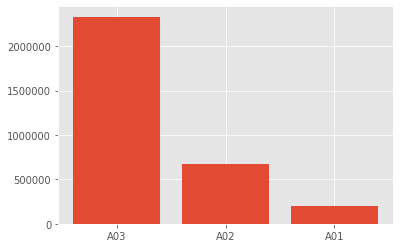

In [121]:
plt.style.use('ggplot')

fig = plt.figure()

ax = fig.add_subplot()
ax.bar(online['biz_unit'].unique(), online['biz_unit'].value_counts())

plt.show()

<br><br>

## Data Saving

- 각 key 값의 순서별로 순서를 매겨 저장합니다.

In [22]:
online = online.sort_values(['clnt_id','sess_id','hit_seq'])
online.to_csv('./data/online_03.csv', index=False)

In [23]:
trade = trade.sort_values(['clnt_id','trans_id','trans_seq'])
trade.to_csv('./data/trade_03.csv',index=False)

In [24]:
customer = customer.sort_values('clnt_id')
customer.to_csv('./data/customer_03.csv',index=False)

In [25]:
item = item.sort_values('pd_c')
item.to_csv('./data/item_03.csv',index=False)